In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import skimage

In [2]:
!ls DRIVE/training/images

21_training.tif 25_training.tif 29_training.tif 33_training.tif 37_training.tif
22_training.tif 26_training.tif 30_training.tif 34_training.tif 38_training.tif
23_training.tif 27_training.tif 31_training.tif 35_training.tif 39_training.tif
24_training.tif 28_training.tif 32_training.tif 36_training.tif 40_training.tif


In [3]:
!ls DRIVE/training/mask
# We are not using masks because we can generate them using OTSU ourselves too for ROI

21_training_mask.gif 28_training_mask.gif 35_training_mask.gif
22_training_mask.gif 29_training_mask.gif 36_training_mask.gif
23_training_mask.gif 30_training_mask.gif 37_training_mask.gif
24_training_mask.gif 31_training_mask.gif 38_training_mask.gif
25_training_mask.gif 32_training_mask.gif 39_training_mask.gif
26_training_mask.gif 33_training_mask.gif 40_training_mask.gif
27_training_mask.gif 34_training_mask.gif


In [4]:
!ls DRIVE/training/1st_manual

21_manual1.gif 25_manual1.gif 29_manual1.gif 33_manual1.gif 37_manual1.gif
22_manual1.gif 26_manual1.gif 30_manual1.gif 34_manual1.gif 38_manual1.gif
23_manual1.gif 27_manual1.gif 31_manual1.gif 35_manual1.gif 39_manual1.gif
24_manual1.gif 28_manual1.gif 32_manual1.gif 36_manual1.gif 40_manual1.gif


In [5]:
IMG_INDEX=21

### Reading image

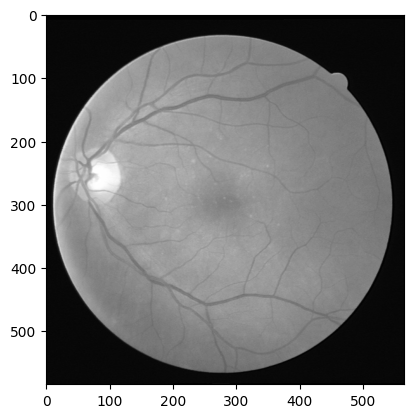

In [6]:
img = cv.imread(f"DRIVE/training/images/{IMG_INDEX}_training.tif")
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap="gray")

## Pre-processing

### Green channel extraction

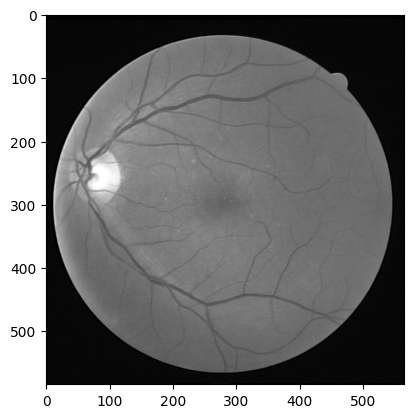

In [7]:
b, g, r = cv.split(img)
img_green = g
plt.imshow(img_green, cmap="gray")

### ROI Extraction (OTSU)

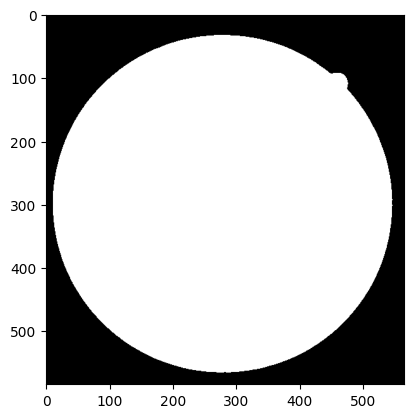

In [8]:
blur = cv.GaussianBlur(img_green,(5,5),0)
_,mask = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.imshow(mask, cmap="gray")

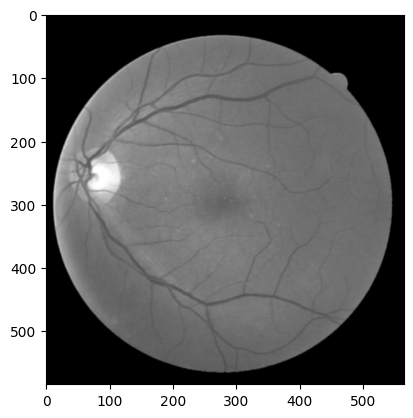

In [9]:
img_mask = cv.bitwise_and(img_green,img_green, mask=mask)
img_mask = cv.GaussianBlur(img_mask, (3,3), 0)
plt.imshow(img_mask, cmap="gray")

### CLAHE Histogram Equalisation

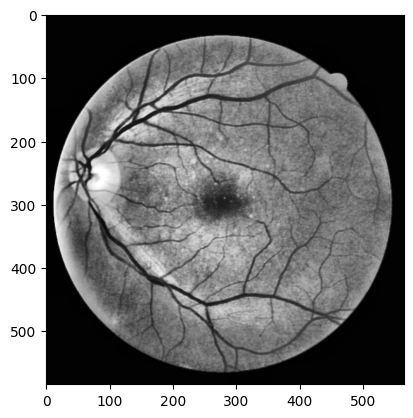

In [10]:
clahe = cv.createCLAHE(clipLimit=7)
img_clahe = clahe.apply(img_mask)
plt.imshow(img_clahe, cmap="gray")

### Image Normalization
Note: The image does not change after normalisation with (0, 255) because CLAHE already does that. If we reduce the normalisation limit to (0, 127) we will observe a difference

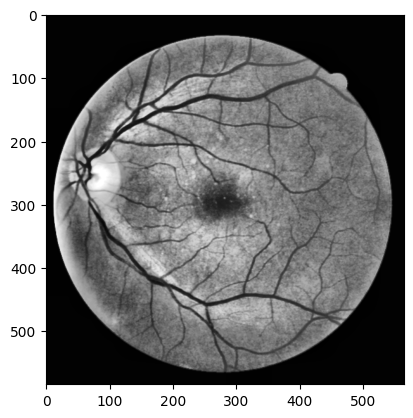

In [11]:
img_norm = cv.normalize(img_clahe, None, 0, 255, cv.NORM_MINMAX)
plt.imshow(img_norm, cmap="gray")

### Morphological Transform (Image Opening)
Image opening is erosion followed by dilusion

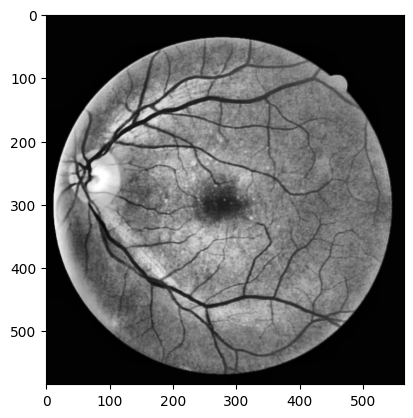

In [12]:
img_erode1 = cv.erode(img_norm, (3,3))
img_open1 = cv.dilate(img_erode1, (3,3))
img_erode2 = cv.erode(img_open1, (5,5))
img_open2 = cv.dilate(img_erode2, (5,5))
img_erode3 = cv.erode(img_open2, (7,7))
img_open3 = cv.dilate(img_erode3, (7,7))
plt.imshow(img_open3, cmap="gray")

## Blood Vessel Enhancement (BVE)

### Frangi Filtering

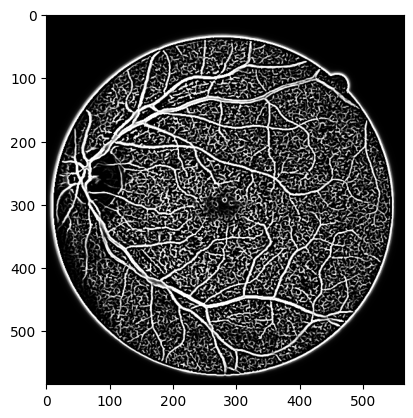

In [13]:
img_frangi = skimage.filters.frangi(img_open3, beta=2, gamma=3.5)
img_frangi = skimage.util.img_as_ubyte(img_frangi)
plt.imshow(img_frangi, cmap="gray")

## Post Processing

### Noise reduction
We find contours then remove small components less than 500 in area

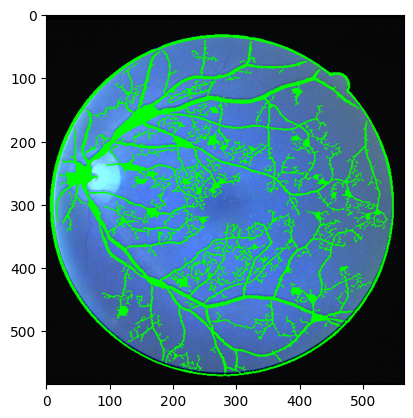

In [14]:
_, img_bw = cv.threshold(img_frangi, 0, 255 ,cv.THRESH_BINARY+cv.THRESH_OTSU)
contours, _ = cv.findContours(img_bw, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

areas = []
ok = []
for contour in contours:
    area = cv.contourArea(contour)
    if area > 500:
        areas.append(area)
        ok.append(contour)

img_test = cv.imread("DRIVE/training/images/21_training.tif")
cv.drawContours(img_test, ok, -1, (0,255,0), cv.FILLED)
plt.imshow(img_test, cmap="gray")

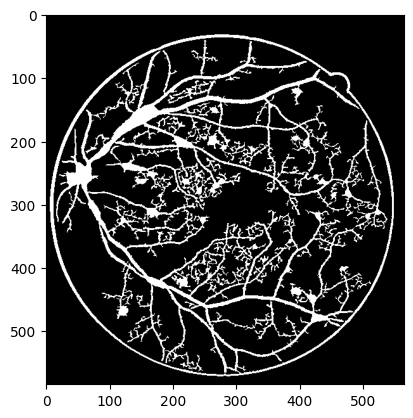

In [15]:
out = np.zeros(img.shape, dtype=np.uint8)
out = cv.cvtColor(out, cv.COLOR_BGR2GRAY)

cv.drawContours(out, ok, -1, (255,255,255), cv.FILLED)
_, out = cv.threshold(out, 0, 255, cv.THRESH_BINARY)
plt.imshow(out, cmap="gray")

### Outer circle removal (Boundary removal)
We observed the mask result is not supposed to have the outer circle.

This outer circle would come in most edge detection methods because it is an edge between the background and the retina, hence, we will remove this by creating a circular mask around the eye and cropping the rest out.

This mask is created by eroding the previous mask

Boundary = A - A(-)B

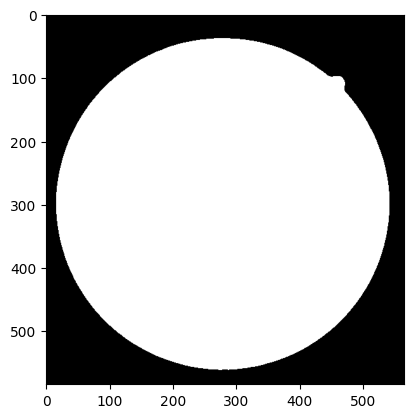

In [16]:
mask_eroded = cv.erode(mask, cv.getStructuringElement(cv.MORPH_ELLIPSE, (10, 10)))
plt.imshow(mask_eroded, cmap="gray")

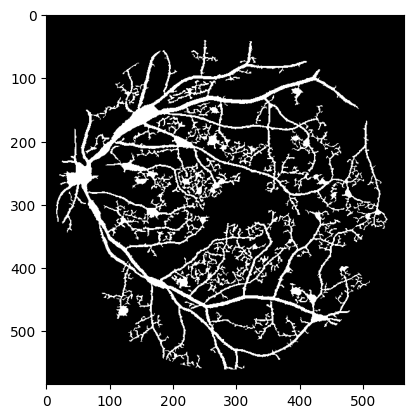

In [17]:
img_masked = cv.bitwise_and(out,out, mask=mask_eroded)
plt.imshow(img_masked,cmap="gray")

In [18]:
cv.imwrite(f"results/final_{IMG_INDEX}.jpg", img_masked)

True

## Result

### Our prediction

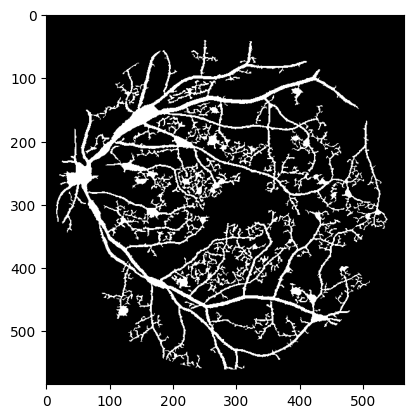

In [19]:
predicted = img_masked
plt.imshow(predicted, cmap="gray")

### Given actual value

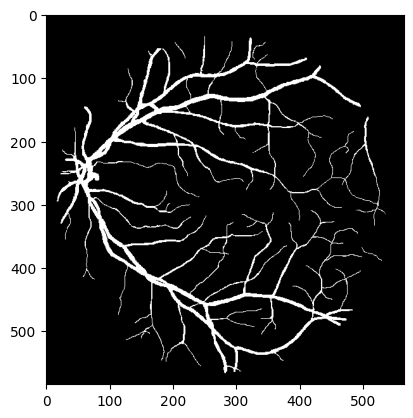

In [20]:
cap = cv.VideoCapture(f"DRIVE/training/1st_manual/{IMG_INDEX}_manual1.gif")
_, actual = cap.read()
actual = cv.cvtColor(actual, cv.COLOR_BGR2GRAY)
_, actual = cv.threshold(actual, 0, 255, cv.THRESH_BINARY)

plt.imshow(actual, cmap="gray")

In [21]:
np.sum(predicted >=0)

329960

In [22]:
np.sum(actual == predicted)

286386

## Analysis

We got same output in **286386 out of 329960 pixels (86.79%)**